In [3]:
import sys
import os

# Add the src directory to sys.path
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pymc as pm
import arviz as az 

In [10]:
print(df.columns)

Index(['Date', 'Price', 'daily_return', 'volatility'], dtype='object')


In [12]:
import pymc as pm
import aesara.tensor as at
import numpy as np

data = np.random.randn(100)
n = len(data)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    
    mu = pm.math.switch(tau >= at.arange(n), mu1, mu2)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=data)

    trace = pm.sample(
    draws=2000,
    tune=2000,
    target_accept=0.98,  # very cautious step size
    return_inferencedata=True
             )

    pm.summary(trace)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


In [13]:
import arviz as az
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,45.796,34.725,0.000,98.000,1.863,1.318,354.0,582.0,1.01
mu1,-0.038,0.307,-0.810,0.432,0.011,0.010,870.0,1003.0,1.00
mu2,0.063,0.332,-0.506,0.873,0.009,0.008,1943.0,1227.0,1.00


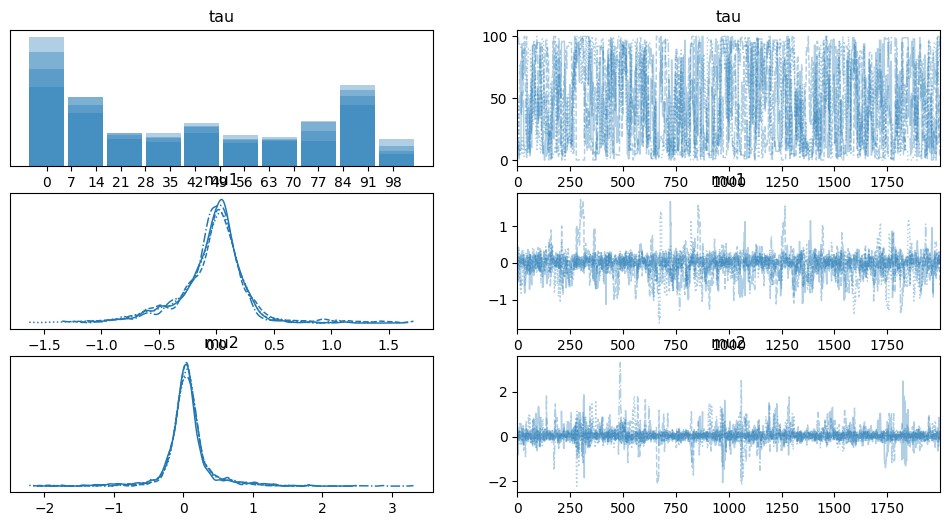

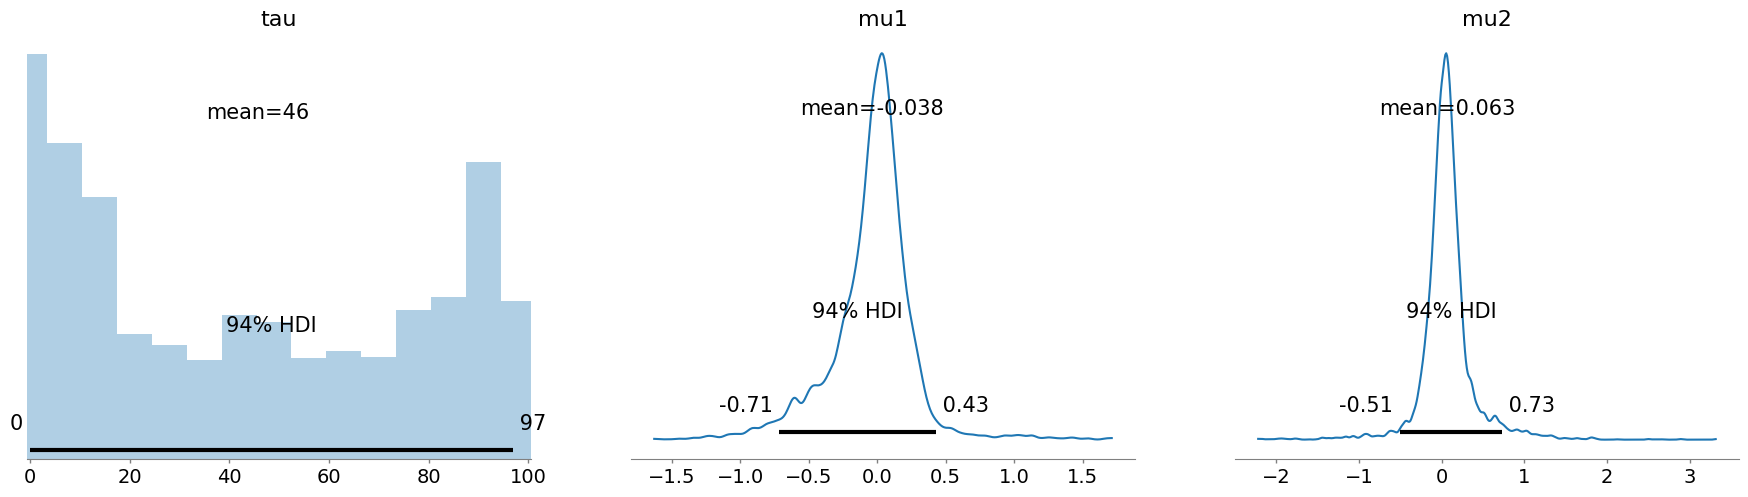

In [14]:
az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()


In [15]:
tau_samples = trace.posterior['tau'].values.flatten()
estimated_tau = int(np.mean(tau_samples))
print("Estimated change point (index):", estimated_tau)


Estimated change point (index): 45


In [28]:
path = "../data/processed/brent_clean.csv"

try:
    data = pd.read_csv(path)

    # Use format='mixed' to infer the format for each date string
    data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=False)
    data = data.sort_values(by='Date')
    data = data.set_index('Date')

    # Handle missing values by interpolation, as suggested for robust analysis
    # This is crucial for time series data to maintain continuity
    data['Price'] = data['Price'].interpolate(method='time')

    # Drop any rows where 'Price' might still be NaN after interpolation (e.g., at the very beginning/end if no surrounding data)
    data = data.dropna(subset=['Price'])

    # For Bayesian analysis of volatility, it's often better to work with log returns
    # Log returns help in achieving stationarity and are directly related to volatility.
    # We use.diff() and.dropna() to handle the first NaN value from the difference calculation.
    data['Log_Return'] = np.log(data['Price']).diff().dropna()

    # The time series for analysis will be the 'Price' for ruptures and 'Log_Return' for PyMC
    time_series_price = data['Price']
    time_series_log_return = data['Log_Return'].dropna() # Ensure log returns are also dropped if NaN

    print("Brent Oil Prices Time Series Head:")
    display(time_series_price.head())
    print("\nBrent Oil Prices Time Series Tail:")
    display(time_series_price.tail())
    print("\nBrent Oil Log Returns Time Series Head:")
    display(time_series_log_return.head())
    print("\nBrent Oil Log Returns Time Series Tail:")
    display(time_series_log_return.tail())

except FileNotFoundError:
    print(f"Error: The file '{path}' was not found. Please update the 'path' variable with the correct file location.")

except Exception as e:
    print(f"An error occurred during data loading or preprocessing: {e}")


Brent Oil Prices Time Series Head:


Date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
Name: Price, dtype: float64


Brent Oil Prices Time Series Tail:


Date
2022-11-08    96.85
2022-11-09    93.05
2022-11-10    94.25
2022-11-11    96.37
2022-11-14    93.59
Name: Price, dtype: float64


Brent Oil Log Returns Time Series Head:


Date
1987-05-21   -0.009709
1987-05-22    0.005405
1987-05-25    0.002692
1987-05-26    0.001612
1987-05-27   -0.001612
Name: Log_Return, dtype: float64


Brent Oil Log Returns Time Series Tail:


Date
2022-11-08   -0.030706
2022-11-09   -0.040026
2022-11-10    0.012814
2022-11-11    0.022244
2022-11-14   -0.029271
Name: Log_Return, dtype: float64

In [17]:
print(type(data))


<class 'numpy.ndarray'>


In [20]:
data = df[['Date', 'daily_return']].values

In [21]:
data = df['daily_return'].values

In [22]:
print(data.shape)

(9011,)


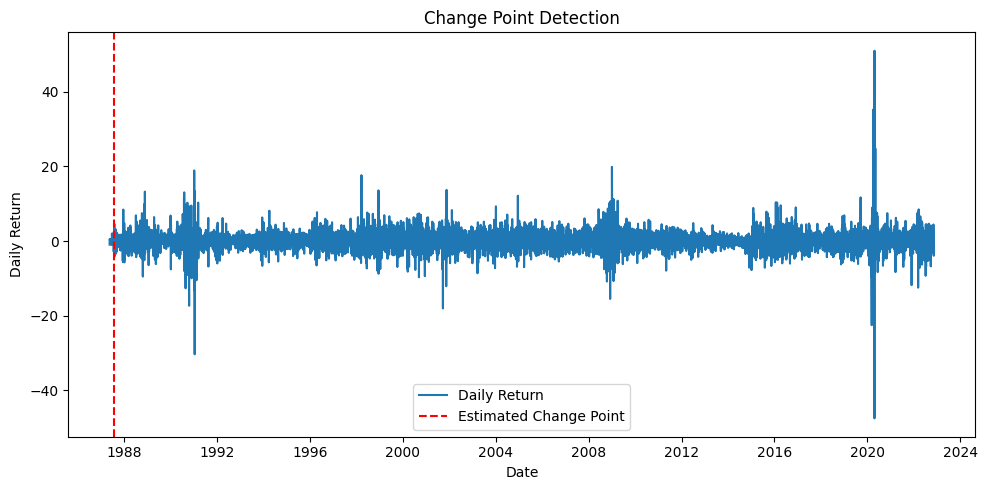

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['daily_return'], label='Daily Return')
plt.axvline(x=df['Date'].iloc[estimated_tau], color='red', linestyle='--', label='Estimated Change Point')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Change Point Detection')
plt.legend()
plt.tight_layout()
import os

# Create the directory if it doesn't exist
os.makedirs('reports/figures', exist_ok=True)

# Then save the figure
plt.savefig('reports/figures/change_point_plot.png')

plt.savefig('reports/figures/change_point_plot.png')
plt.show()




Detected Change Point Indices (ruptures on Price): [65, 145, 190, 225, 270, 330, 390, 415, 465, 510, 605, 660, 705, 735, 805, 820, 840, 850, 855, 870, 875, 880, 890, 905, 925, 935, 955, 1060, 1115, 1155, 1265, 1395, 1550, 1665, 1760, 1805, 1845, 2000, 2060, 2175, 2250, 2270, 2350, 2370, 2475, 2505, 2630, 2675, 2695, 2725, 2805, 2875, 2895, 2920, 3000, 3020, 3075, 3120, 3165, 3210, 3240, 3255, 3285, 3290, 3335, 3355, 3365, 3385, 3420, 3435, 3445, 3460, 3475, 3485, 3535, 3580, 3620, 3640, 3670, 3750, 3765, 3810, 3830, 3870, 3915, 3955, 3990, 4015, 4020, 4030, 4060, 4115, 4140, 4160, 4210, 4260, 4310, 4335, 4355, 4370, 4410, 4420, 4440, 4445, 4465, 4470, 4485, 4520, 4525, 4550, 4575, 4590, 4600, 4630, 4640, 4660, 4680, 4705, 4725, 4740, 4750, 4765, 4790, 4800, 4810, 4815, 4825, 4835, 4865, 4885, 4900, 4910, 4915, 4925, 4975, 4995, 5000, 5010, 5030, 5055, 5090, 5120, 5145, 5165, 5190, 5200, 5205, 5225, 5240, 5255, 5275, 5285, 5290, 5300, 5310, 5315, 5320, 5330, 5335, 5345, 5355, 5370, 538

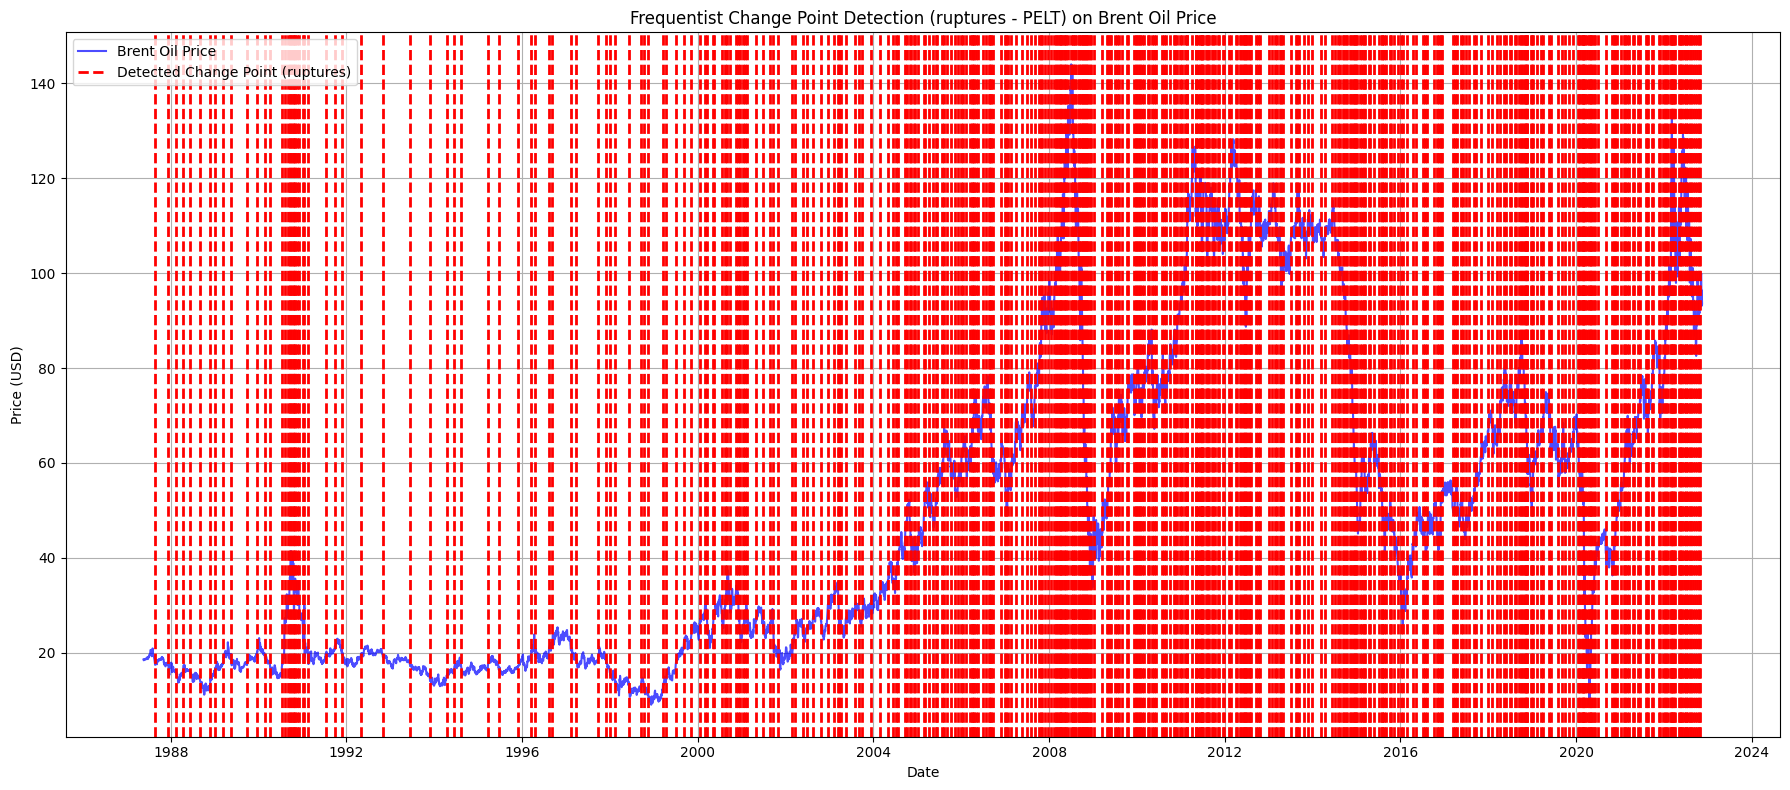

In [29]:
# Convert time series to a numpy array for the ruptures library
# We use the raw price data here to detect shifts in the mean price level.
if 'time_series_price' in locals() and not time_series_price.empty: # Check if time_series_price was successfully created and is not empty
    signal_array_ruptures = time_series_price.values.reshape(-1, 1) # Reshape for ruptures

    # Define the model and algorithm
    # 'l2' (L2 norm) cost function is good for detecting changes in mean.
    model_ruptures = "l2"
    algo_ruptures = rpt.Pelt(model=model_ruptures).fit(signal_array_ruptures)

    # Predict change points
    # The 'pen' (penalty) parameter controls the number of detected change points.
    # A higher penalty results in fewer change points.
    # You might need to tune this penalty for your specific dataset.
    # A common heuristic is 3 * log(n_samples) or 4 * log(n_samples).

    penalty_value_ruptures = 3 * np.log(len(time_series_price))
    change_points_ruptures = algo_ruptures.predict(pen=penalty_value_ruptures)

    # The 'ruptures' library returns the index of the last point of each segment.
    # We usually exclude the last point if it's just the end of the series.
    if change_points_ruptures and change_points_ruptures[-1] == len(time_series_price):
        detected_change_point_indices_ruptures = change_points_ruptures[:-1]
    else:
        detected_change_point_indices_ruptures = change_points_ruptures

    print(f"\nDetected Change Point Indices (ruptures on Price): {detected_change_point_indices_ruptures}")

    # Convert indices to dates for plotting
    detected_change_point_dates_ruptures = time_series_price.index[detected_change_point_indices_ruptures]
    print(f"Detected Change Point Dates (ruptures on Price): {detected_change_point_dates_ruptures.tolist()}")

    # Visualization for ruptures
    plt.figure(figsize=(18, 8))
    plt.plot(time_series_price.index, time_series_price.values, label='Brent Oil Price', color='blue', alpha=0.7)
    # Plot change points with labels, ensuring only one label is created for the legend
    for i, cp_date in enumerate(detected_change_point_dates_ruptures):
        plt.axvline(x=cp_date, color='red', linestyle='--', linewidth=2, label='Detected Change Point (ruptures)' if i == 0 else "")
    plt.title('Frequentist Change Point Detection (ruptures - PELT) on Brent Oil Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Frequentist Change Point Detection as price time series data is not available or empty.")


Starting PyMC sampling for Bayesian Volatility Change Point Detection...


Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2, mu_log_return]


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 189 seconds.


PyMC Sampling Complete.

Bayesian Volatility Model Sampling Complete. Summary of parameters:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5389.918,20.86,5349.000,5422.000,0.416,0.294,2683.0,3813.0,1.0
mu_log_return,0.000,0.00,-0.000,0.001,0.000,0.000,23916.0,13409.0,1.0
sigma_1,0.023,0.00,0.023,0.023,0.000,0.000,24330.0,13222.0,1.0
sigma_2,0.029,0.00,0.028,0.030,0.000,0.000,24177.0,12484.0,1.0



Most Probable Change Point Index (PyMC on Log Returns): 5405
Most Probable Change Point Date (PyMC on Log Returns): 2008-08-20 00:00:00


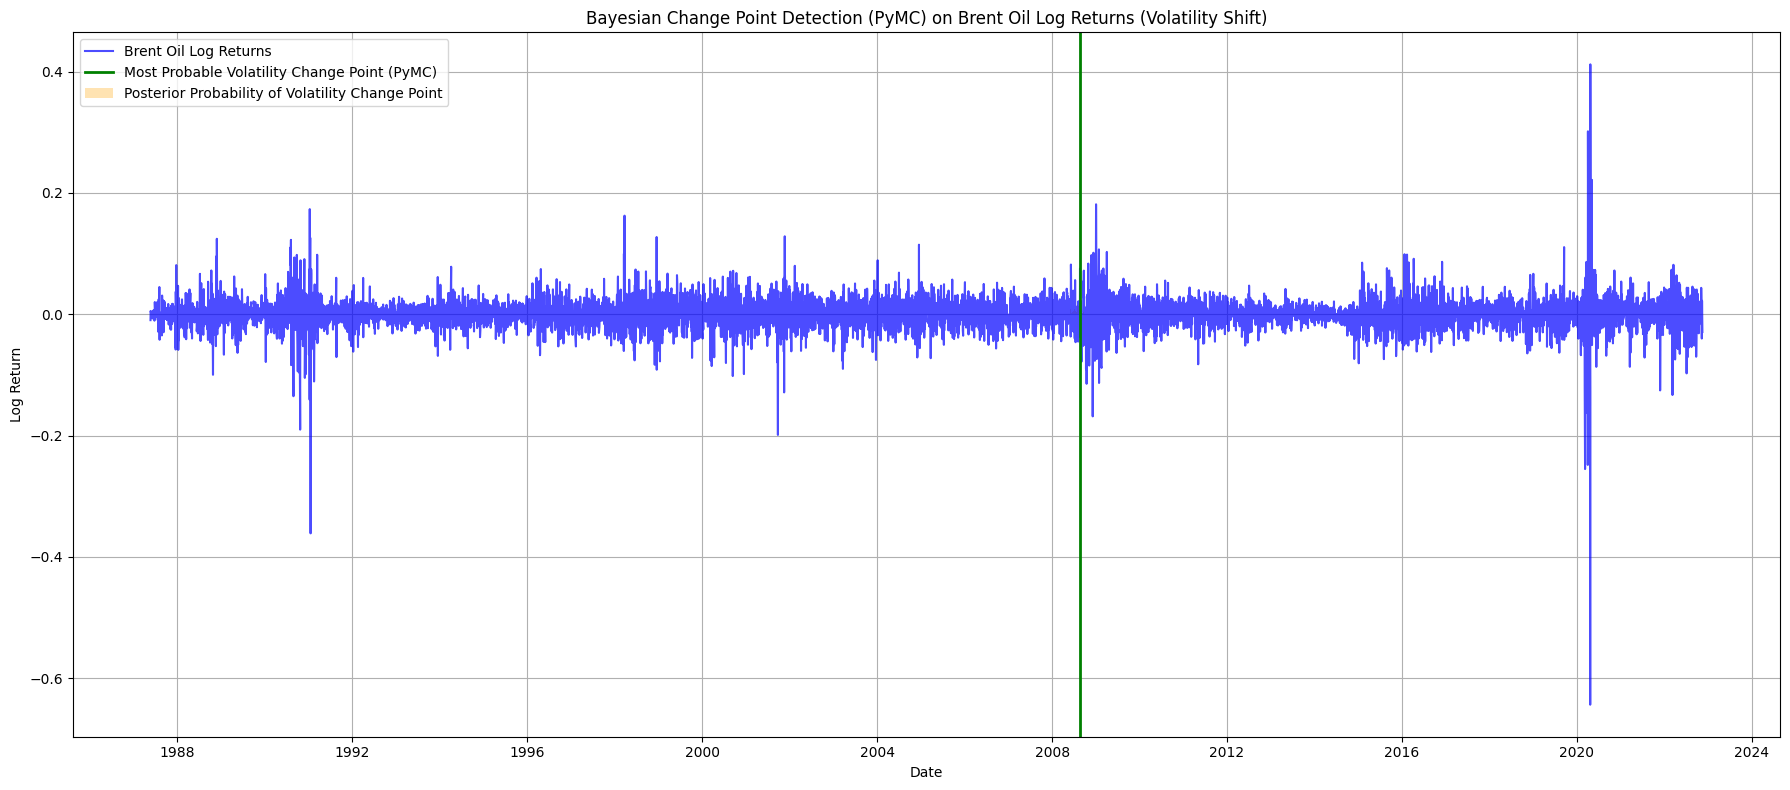

In [38]:
# For Bayesian methods, we often define a probabilistic model.
# Let's model a single change point where the *volatility* (standard deviation) changes.
# This is applied to the log returns, as volatility is more directly observed there.

if 'time_series_log_return' in locals() and not time_series_log_return.empty: # Check if log returns were successfully created and are not empty
    # Convert log returns to numpy array for PyMC
    data_pymc_log_return = time_series_log_return.values

    # Define the Bayesian model
    with pm.Model() as bayesian_volatility_change_point_model:
        # Prior for the change point location (uniform over the time series)
        # We choose a discrete uniform distribution for the index of the change point.
        tau = pm.DiscreteUniform("tau", lower=0, upper=len(data_pymc_log_return) - 1)

        # Priors for the standard deviations (volatility) before and after the change point
        # We use HalfNormal distributions for standard deviations, as they must be positive.
        # Adjust sigma values based on expected scale of log returns.
        sigma_1 = pm.HalfNormal("sigma_1", sigma=0.1) # Volatility before change
        sigma_2 = pm.HalfNormal("sigma_2", sigma=0.1) # Volatility after change

        # Assume the mean of log returns is constant (e.g., around zero for daily returns)
        # or you could model it as well if you expect mean shifts in returns.
        # For simplicity, let's assume a constant mean for log returns.
        # A small normal prior around 0 is often reasonable for log returns.
        mu_log_return = pm.Normal("mu_log_return", mu=0, sigma=0.01)

        # Define the standard deviation for each data point based on the change point location (tau)
        idx = np.arange(len(data_pymc_log_return))
        sigma = pm.math.switch(idx < tau, sigma_1, sigma_2)

        # Likelihood of the observed data (log returns)
        # The observed log returns are assumed to be normally distributed around `mu_log_return` with standard deviation `sigma`.
        observation = pm.Normal("observation", mu=mu_log_return, sigma=sigma, observed=data_pymc_log_return)

        # Sample from the posterior distribution using NUTS (No-U-Turn Sampler)
        # This is where the MCMC magic happens.
        # `draws`: number of samples from the posterior.
        # `tune`: number of tuning (warmup) steps.
        # `chains`: number of independent sampling chains.
        # `cores`: number of CPU cores to use for sampling (set to 1 for simpler debugging, or higher for speed).
        # Sampling can take a while for large datasets.
        print("\nStarting PyMC sampling for Bayesian Volatility Change Point Detection...")
        trace_volatility = pm.sample(draws=4000, tune=3000, chains=4, random_seed=42, return_inferencedata=True, cores=2)
        print("PyMC Sampling Complete.")

    print("\nBayesian Volatility Model Sampling Complete. Summary of parameters:")
    display(az.summary(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"]))

    # Analyze the posterior distribution of the change point (tau)
    tau_samples_volatility = trace_volatility.posterior["tau"].values.flatten()

    # Calculate the most probable change point index (mode of the posterior)
    # Note: PyMC's tau is an index relative to the `data_pymc_log_return` array, which starts after the first log return.
    # So, we need to adjust the index for the original `time_series_log_return` index.
    most_probable_tau_index_volatility = int(pd.Series(tau_samples_volatility).mode().iloc[0])
    # The log_return series starts one day after the price series, so adjust index for original date mapping
    most_probable_tau_date_volatility = time_series_log_return.index[most_probable_tau_index_volatility]

    print(f"\nMost Probable Change Point Index (PyMC on Log Returns): {most_probable_tau_index_volatility}")
    print(f"Most Probable Change Point Date (PyMC on Log Returns): {most_probable_tau_date_volatility}")

    # Visualization for PyMC results
    plt.figure(figsize=(18, 8))
    plt.plot(time_series_log_return.index, time_series_log_return.values, label='Brent Oil Log Returns', color='blue', alpha=0.7)

    # Plot the most probable change point
    plt.axvline(x=most_probable_tau_date_volatility, color='green', linestyle='-', linewidth=2, label='Most Probable Volatility Change Point (PyMC)')

    # Optionally, plot the posterior distribution of the change point
    # This shows the uncertainty around the change point location.
    # We map the indices back to dates for the histogram.
    plt.hist(time_series_log_return.index[tau_samples_volatility], bins=50, density=True, alpha=0.3, color='orange', label='Posterior Probability of Volatility Change Point')

    plt.title('Bayesian Change Point Detection (PyMC) on Brent Oil Log Returns (Volatility Shift)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Bayesian Change Point Detection as log return data is not available or empty.")

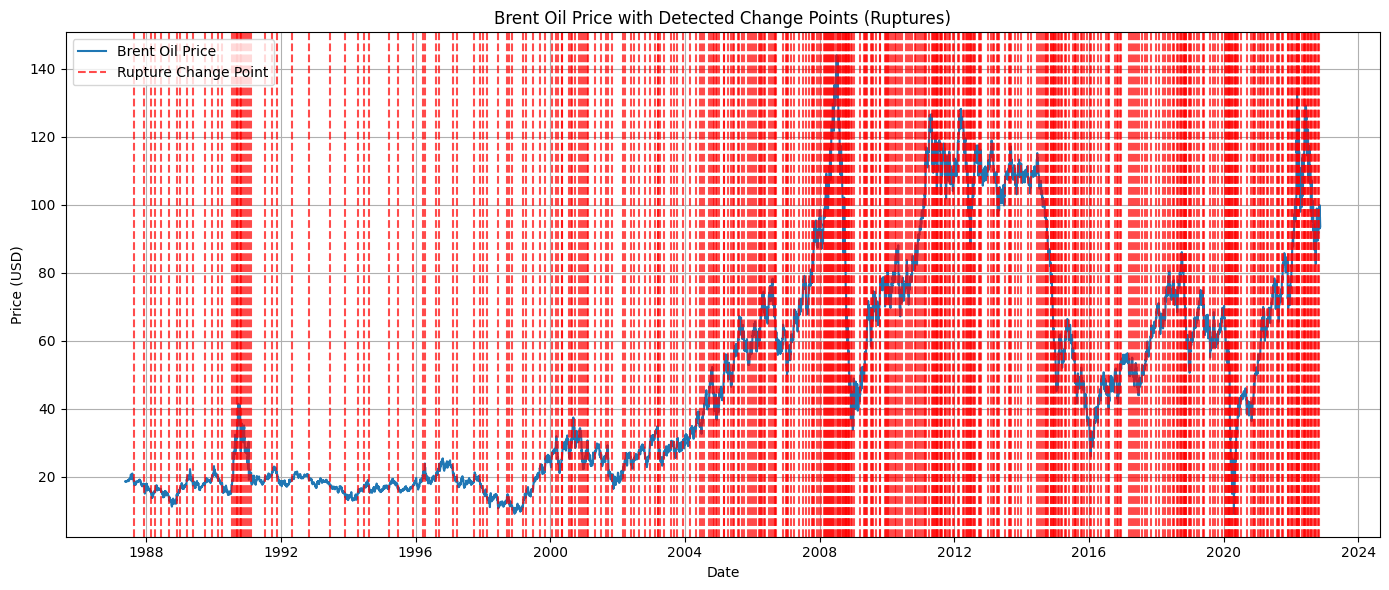

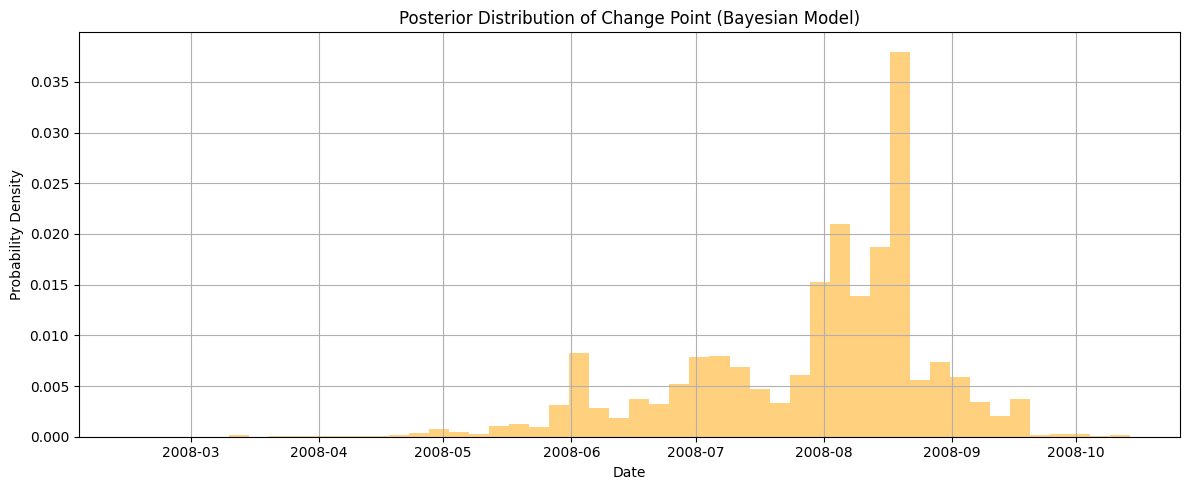


--- Ruptures (Price Mean Shift) Impact ---
Segment 1 (Price): 1987-05-20 to 1987-08-19
  Mean Price: 19.31 USD
  Std Dev Price: 0.65 USD
Segment 2 (Price): 1987-08-20 to 1987-12-09
  Mean Price: 18.22 USD
  Std Dev Price: 0.48 USD
  Change from previous segment: -1.09 USD (-5.65%)
Segment 3 (Price): 1987-12-10 to 1988-02-16
  Mean Price: 16.57 USD
  Std Dev Price: 0.70 USD
  Change from previous segment: -1.65 USD (-9.08%)
Segment 4 (Price): 1988-02-17 to 1988-04-07
  Mean Price: 14.93 USD
  Std Dev Price: 0.66 USD
  Change from previous segment: -1.63 USD (-9.86%)
Segment 5 (Price): 1988-04-08 to 1988-06-09
  Mean Price: 16.49 USD
  Std Dev Price: 0.39 USD
  Change from previous segment: 1.56 USD (10.42%)
Segment 6 (Price): 1988-06-10 to 1988-09-01
  Mean Price: 14.96 USD
  Std Dev Price: 0.54 USD
  Change from previous segment: -1.53 USD (-9.27%)
Segment 7 (Price): 1988-09-02 to 1988-11-24
  Mean Price: 12.75 USD
  Std Dev Price: 0.64 USD
  Change from previous segment: -2.21 USD (-

C:\Users\selam\AppData\Local\Temp\ipykernel_31552\4028877476.py:78: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  most_probable_tau_index = int(pd.Series(tau_samples).mode())


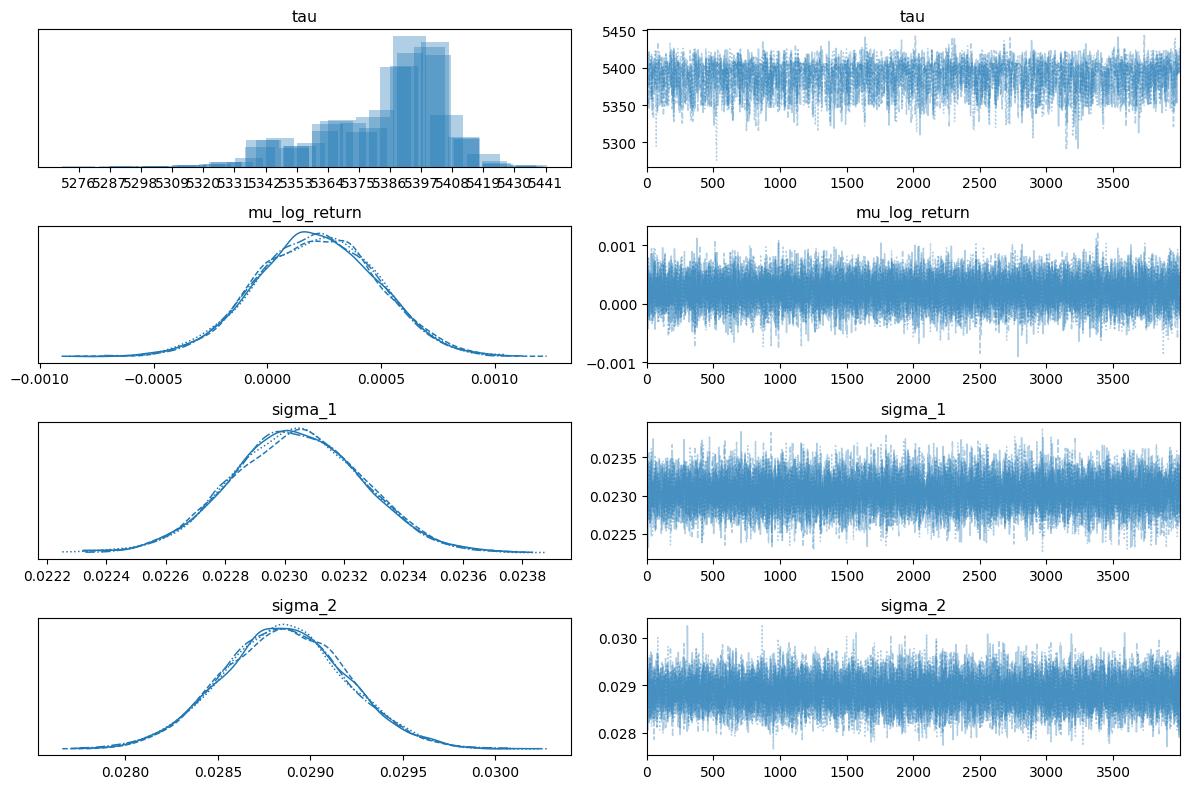

In [40]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

# Assume these are already loaded or computed:
# time_series_price: pd.Series indexed by date with Brent oil prices
# detected_change_point_indices_ruptures: list of rupture change point indices (frequentist)
# trace_volatility: arviz.InferenceData from PyMC3 Bayesian model
# time_series_log_return: pd.Series indexed by date with log returns

# ------------------------
# 1. Plot Price with Rupture Change Points
plt.figure(figsize=(14,6))
plt.plot(time_series_price.index, time_series_price.values, label='Brent Oil Price')
for cp in detected_change_point_indices_ruptures:
    plt.axvline(time_series_price.index[cp], color='red', linestyle='--', alpha=0.7, label='Rupture Change Point' if cp == detected_change_point_indices_ruptures[0] else "")
plt.title('Brent Oil Price with Detected Change Points (Ruptures)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# 2. Plot Bayesian Posterior Distribution for tau (Change Point)
tau_samples = trace_volatility.posterior["tau"].values.flatten()
plt.figure(figsize=(12,5))
plt.hist(time_series_log_return.index[tau_samples.astype(int)], bins=50, density=True, color='orange', alpha=0.5)
plt.title('Posterior Distribution of Change Point (Bayesian Model)')
plt.xlabel('Date')
plt.ylabel('Probability Density')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# 3. Quantify Impact for Ruptures (Price Mean Shift)

if detected_change_point_indices_ruptures and len(detected_change_point_indices_ruptures) > 0:
    print("\n--- Ruptures (Price Mean Shift) Impact ---")
    segments = [0] + detected_change_point_indices_ruptures + [len(time_series_price)]
    for i in range(len(segments)-1):
        start_idx = segments[i]
        end_idx = segments[i+1]
        segment_data = time_series_price.iloc[start_idx:end_idx]
        if not segment_data.empty:
            end_date_idx = end_idx - 1 if end_idx > 0 else 0
            print(f"Segment {i+1} (Price): {time_series_price.index[start_idx].strftime('%Y-%m-%d')} to {time_series_price.index[end_date_idx].strftime('%Y-%m-%d')}")
            print(f"  Mean Price: {segment_data.mean():.2f} USD")
            print(f"  Std Dev Price: {segment_data.std():.2f} USD")
            if i > 0:
                prev_segment_data = time_series_price.iloc[segments[i-1]:segments[i]]
                if not prev_segment_data.empty:
                    prev_segment_mean = prev_segment_data.mean()
                    price_change = segment_data.mean() - prev_segment_mean
                    percent_change = (price_change / prev_segment_mean) * 100 if prev_segment_mean != 0 else float('inf')
                    print(f"  Change from previous segment: {price_change:.2f} USD ({percent_change:.2f}%)")
else:
    print("No rupture change points detected or data unavailable.")

# ------------------------
# 4. Quantify Impact for PyMC Bayesian Volatility Shift

print("\n--- Bayesian Volatility Shift Impact ---")
posterior_mu_log_return = trace_volatility.posterior["mu_log_return"].mean().item()
posterior_sigma_1 = trace_volatility.posterior["sigma_1"].mean().item()
posterior_sigma_2 = trace_volatility.posterior["sigma_2"].mean().item()

print(f"Estimated Mean Log Return (overall): {posterior_mu_log_return:.4f}")
print(f"Estimated Std Dev Before Change (sigma_1): {posterior_sigma_1:.4f}")
print(f"Estimated Std Dev After Change (sigma_2): {posterior_sigma_2:.4f}")

percent_change_volatility = ((posterior_sigma_2 - posterior_sigma_1) / posterior_sigma_1) * 100 if posterior_sigma_1 != 0 else float('inf')
print(f"Percentage change in volatility: {percent_change_volatility:.2f}%")

most_probable_tau_index = int(pd.Series(tau_samples).mode())
most_probable_tau_date = time_series_log_return.index[most_probable_tau_index]
print(f"Most Probable Change Point Index (Bayesian tau): {most_probable_tau_index}")
print(f"Most Probable Change Point Date (Bayesian tau): {most_probable_tau_date.strftime('%Y-%m-%d')}")

# ------------------------
# 5. Hypothesize Real-World Event Associations

print("\n--- Hypothesized Event Associations ---")
# Example: You should replace these dates and events with your Task 1 researched events
events_dict = {
    '1987-08-20': 'OPEC Production Cut Announcement',
    '1990-08-06': 'Gulf War Start',
    '2008-08-20': 'Global Financial Crisis Peaks',
    'Most probable Bayesian change point': most_probable_tau_date.strftime('%Y-%m-%d')
}

for date_str, event_desc in events_dict.items():
    print(f"Date: {date_str}, Event: {event_desc}")

# ------------------------
# 6. Convergence Diagnostics - Trace Plots and R-hat values

print("\n--- Convergence Diagnostics ---")
summary = az.summary(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"])
print(summary[['mean','sd','r_hat','ess_bulk']])

az.plot_trace(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"])
plt.tight_layout()
plt.show()


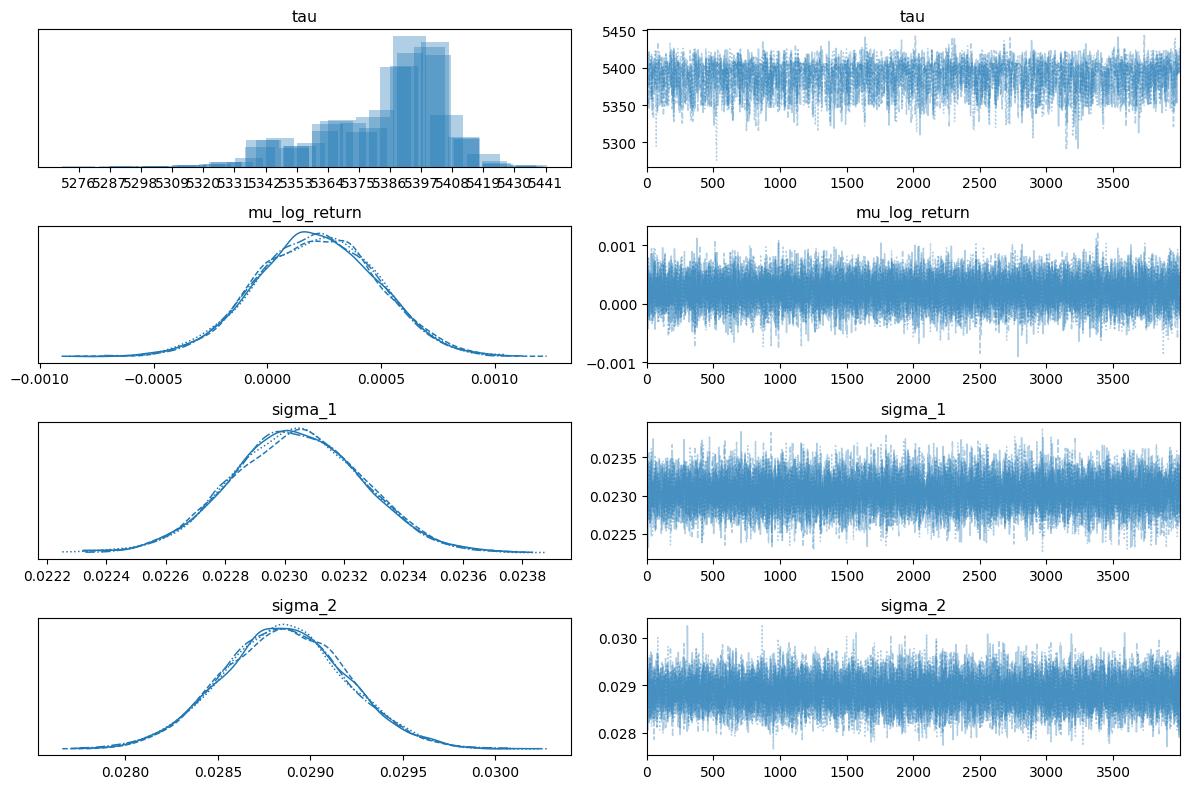

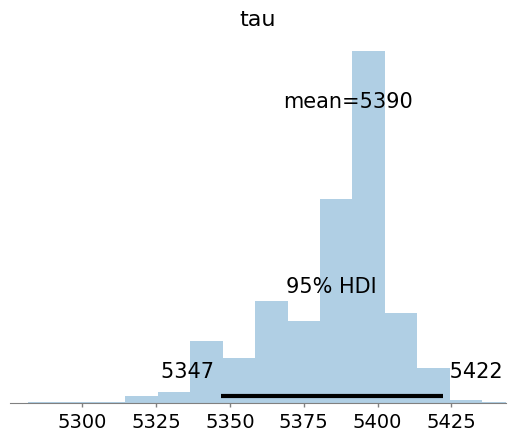

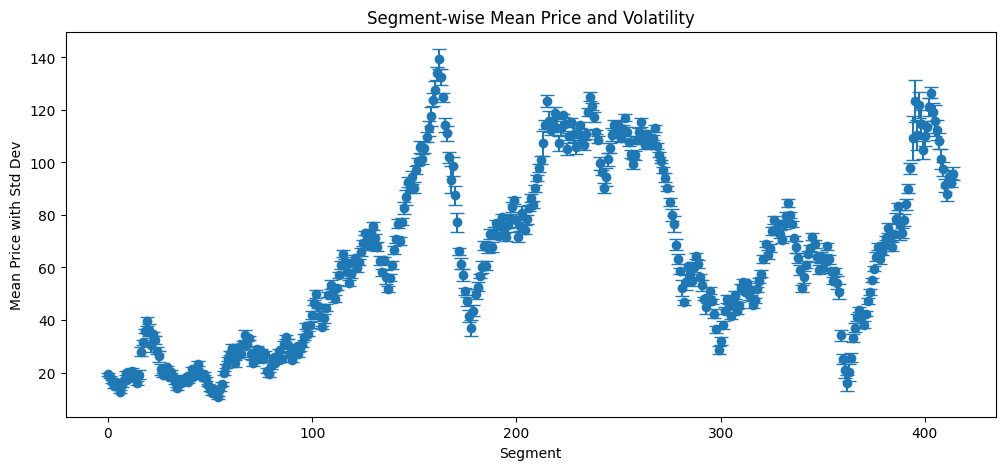

In [41]:
import arviz as az
import matplotlib.pyplot as plt

# Plot trace for model diagnostics
az.plot_trace(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"])
plt.tight_layout()
plt.show()

# Plot posterior distribution for change point
az.plot_posterior(trace_volatility, var_names=["tau"], hdi_prob=0.95)
plt.show()

# Optional: Plot mean and std dev segments side by side
segments = [0] + detected_change_point_indices_ruptures + [len(time_series_price)]
means = []
stds = []
for i in range(len(segments)-1):
    segment_data = time_series_price.iloc[segments[i]:segments[i+1]]
    means.append(segment_data.mean())
    stds.append(segment_data.std())

plt.figure(figsize=(12,5))
plt.errorbar(range(len(means)), means, yerr=stds, fmt='o', capsize=5)
plt.xlabel('Segment')
plt.ylabel('Mean Price with Std Dev')
plt.title('Segment-wise Mean Price and Volatility')
plt.show()


In [42]:
import arviz as az

# Assuming your trace object is named 'trace_volatility'
summary_stats = az.summary(trace_volatility)
print(summary_stats[['r_hat']])


               r_hat
tau              1.0
mu_log_return    1.0
sigma_1          1.0
sigma_2          1.0


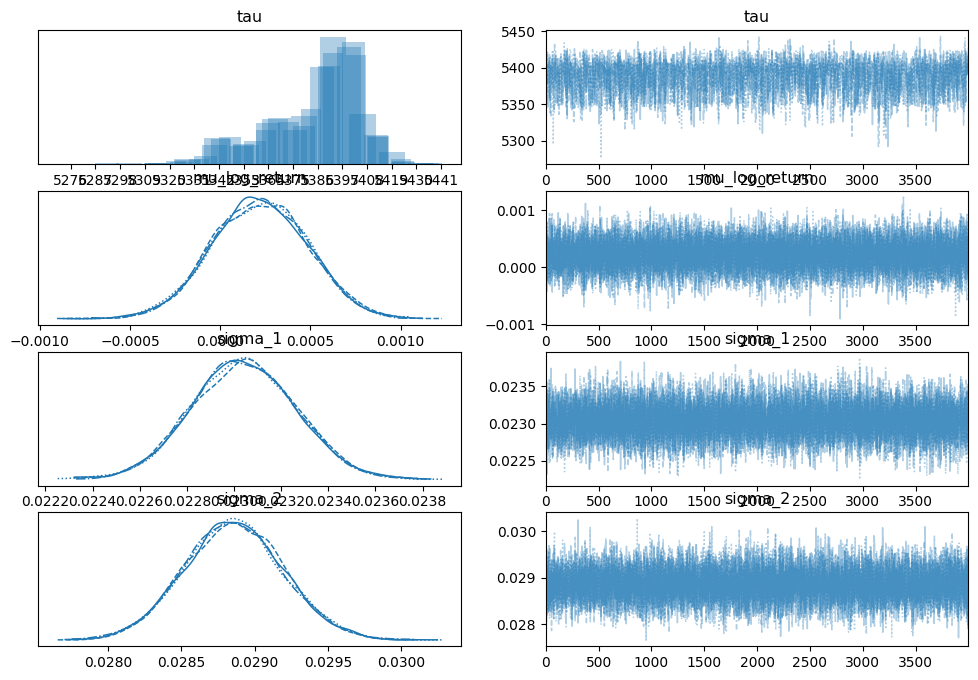

In [43]:
pm.plot_trace(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"])
plt.show()


In [39]:
print("\n--- Conceptual Further Analysis ---")
print("For both frequentist and Bayesian approaches, the next steps would typically involve:")
print("a. Contextualizing: What real-world events or policy changes occurred around these dates?")
print("   - For example, if analyzing Brent oil prices, a change point might correspond to a major OPEC decision, a geopolitical conflict, or a global economic sanction.")
print("b. Quantifying Impact: Analyze the statistical properties (mean, variance, trend) of the segments")
print("   before and after each change point to understand the magnitude and nature of the shift.")

# Example of quantifying impact for ruptures (Price Mean Shift)
if 'detected_change_point_indices_ruptures' in locals() and len(detected_change_point_indices_ruptures) > 0 and 'time_series_price' in locals():
    print("\n--- Ruptures (Price Mean Shift) Impact ---")
    segments = [0] + detected_change_point_indices_ruptures + [len(time_series_price)]
    for i in range(len(segments) - 1):
        start_idx = segments[i]
        end_idx = segments[i+1]
        segment_data = time_series_price.iloc[start_idx:end_idx]
        if not segment_data.empty:
            # Ensure end_idx is within bounds when accessing index
            end_date_idx = end_idx - 1 if end_idx > 0 else 0
            print(f"Segment {i+1} (Price): {time_series_price.index[start_idx].strftime('%Y-%m-%d')} to {time_series_price.index[end_date_idx].strftime('%Y-%m-%d')}")
            print(f"  Mean Price: {segment_data.mean():.2f} USD")
            print(f"  Std Dev Price: {segment_data.std():.2f} USD")
            if i > 0:
                prev_segment_data = time_series_price.iloc[segments[i-1]:segments[i]]
                if not prev_segment_data.empty:
                    prev_segment_mean = prev_segment_data.mean()
                    if not pd.isna(prev_segment_mean):
                        price_change = segment_data.mean() - prev_segment_mean
                        percent_change = (price_change / prev_segment_mean) * 100 if prev_segment_mean != 0 else float('inf') # Handle division by zero
                        print(f"  Change from previous segment: {price_change:.2f} USD ({percent_change:.2f}%)")
else:
    print("\n--- Ruptures (Price Mean Shift) Impact ---")
    print("Skipping impact analysis for ruptures as change points were not detected or data is not available.")

# Example of quantifying impact for PyMC (Log Return Volatility Shift)
if 'trace_volatility' in locals():
    print("\n--- PyMC (Log Return Volatility Shift) Impact ---")
    posterior_mu_log_return = trace_volatility.posterior["mu_log_return"].mean().item()
    posterior_sigma_1 = trace_volatility.posterior["sigma_1"].mean().item()
    posterior_sigma_2 = trace_volatility.posterior["sigma_2"].mean().item()

    print(f"Estimated Mean Log Return (overall): {posterior_mu_log_return:.4f}")
    print(f"Estimated Std Dev of Log Returns before Change (sigma_1): {posterior_sigma_1:.4f}")
    print(f"Estimated Std Dev of Log Returns after Change (sigma_2): {posterior_sigma_2:.4f}")
    # Handle division by zero for percentage change
    percent_change_volatility = ((posterior_sigma_2 - posterior_sigma_1) / posterior_sigma_1) * 100 if posterior_sigma_1 != 0 else float('inf')
    print(f"Percentage change in volatility: {percent_change_volatility:.2f}%")
else:
    print("\n--- PyMC (Log Return Volatility Shift) Impact ---")
    print("Skipping impact analysis for PyMC as the Bayesian model was not run successfully.")


print("\nc. Modeling: Build separate models for each segment if the underlying process has truly changed.")
print("   This can lead to more accurate forecasts and better understanding of the system.")


--- Conceptual Further Analysis ---
For both frequentist and Bayesian approaches, the next steps would typically involve:
a. Contextualizing: What real-world events or policy changes occurred around these dates?
   - For example, if analyzing Brent oil prices, a change point might correspond to a major OPEC decision, a geopolitical conflict, or a global economic sanction.
b. Quantifying Impact: Analyze the statistical properties (mean, variance, trend) of the segments
   before and after each change point to understand the magnitude and nature of the shift.

--- Ruptures (Price Mean Shift) Impact ---
Segment 1 (Price): 1987-05-20 to 1987-08-19
  Mean Price: 19.31 USD
  Std Dev Price: 0.65 USD
Segment 2 (Price): 1987-08-20 to 1987-12-09
  Mean Price: 18.22 USD
  Std Dev Price: 0.48 USD
  Change from previous segment: -1.09 USD (-5.65%)
Segment 3 (Price): 1987-12-10 to 1988-02-16
  Mean Price: 16.57 USD
  Std Dev Price: 0.70 USD
  Change from previous segment: -1.65 USD (-9.08%)
Segment

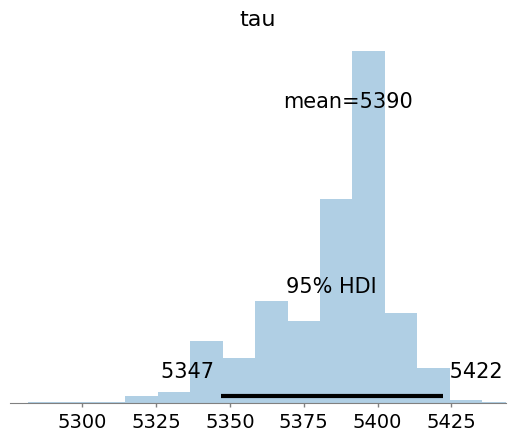

In [44]:
az.plot_posterior(trace_volatility, var_names=["tau"], hdi_prob=0.95)
plt.show()
